# Research Question 3: How do important politicans of right-wing parties position themselves on different topics (immigration, climate change, EU, discrimination, covid, terrorism, russia, israeli palestenian conflict)?

In [1]:
#default imports
import pandas as pd
import numpy as np

#for TextBlob
from textblob import TextBlob
from src.sentiment_analysis import get_subjectivity, get_polarity, get_sentiment

#for Vader
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

#helper fuctions for this notebook
from scripts.rs3_helper import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Step1: Who are the most important right-wing politicians?

In order to answer this first question, we start by loading all quotes related to the list of topics, that we previously extracted during our analysis for Research Question 1. We decided to select the right-wing "popular politicians" using only the extracted quotes related to the list of topics, instead of using all quotes, since there might be politicians who were only quoted very often on topics, which are not examined in this analysis.

In [2]:
path_to_topics_data = 'data/topics/'

topics = ['covid', 'terrorism', 'immigration', 'europe', 'discrimination', 'russia', 'israeli_palestinian', 'climate_change']

quotes = dict()

for topic in topics:
    quotes[topic] = pd.read_csv(path_to_topics_data + topic + '_quotes')

In [3]:
all_political_quotes = pd.concat(quotes.values())

We chose the most popular right-wing party of each country we wanted to analyse. Except for Spain, there does not seem to be any "relevant" spanish right-wing party. Only a few far-right partys, which do not appear in the dataset at all or in the case of "Vox" only with a handful of quotes. This is why we chose Spains's center-right party instead. 

In [4]:
all_political_quotes.query('political_party == "Vox"')['quotation'].count()

17

These are the partys to be examined:

In [5]:
right_partys = {'Italy':'Lega Nord', 'Germany':'Alternative for Germany', 'France':'National Rally', 'Poland':'Law and Justice', 'Spain':'People\'s Party'}

In order to compare the prominent right-wing politicians, we look at the most quoted politicians of each party and choose the first one, since he/she is the publicly most present member of his/her party.

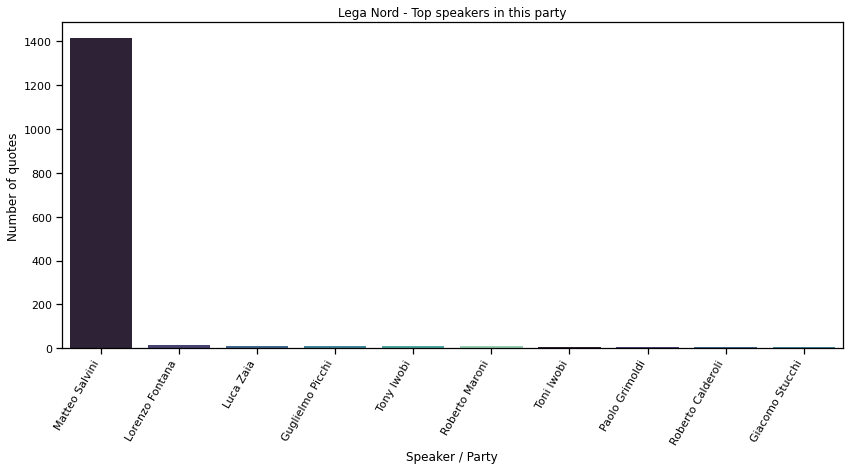

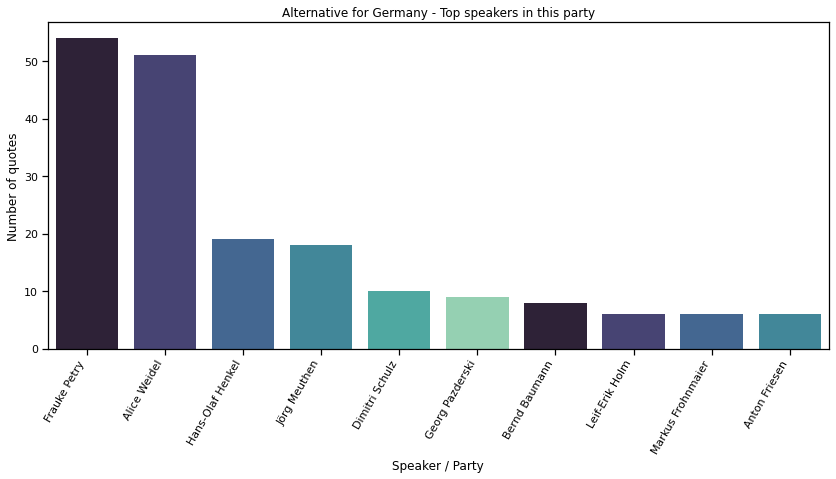

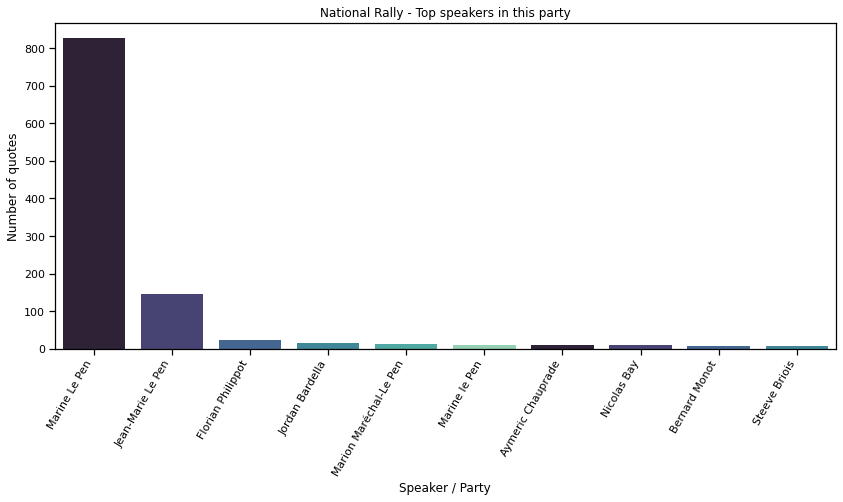

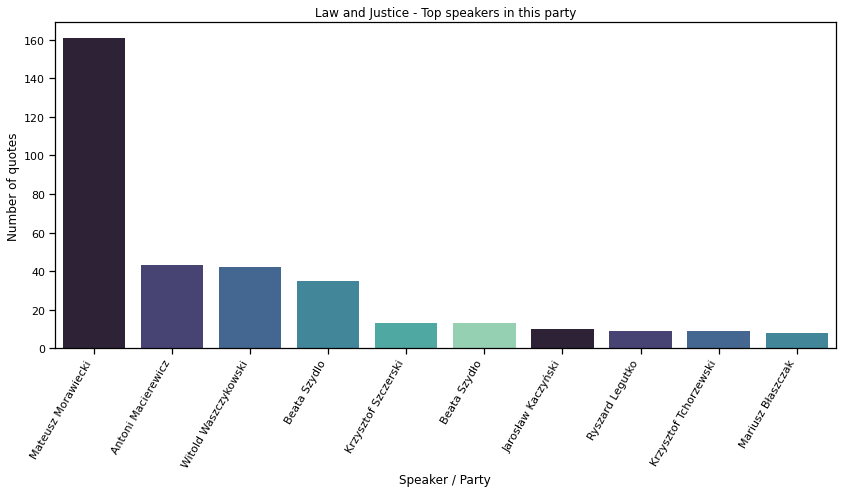

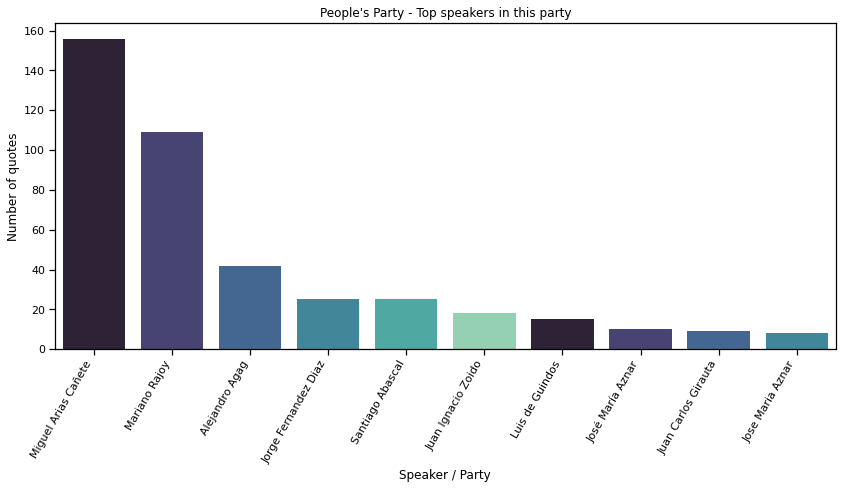

In [6]:
top_speaker_by_party = dict()

for party in right_partys.values():
    party_quotes = all_political_quotes.query('political_party == "' + party + '"')
    top_speaker_by_party[party] = show_top_k_speakers_party(party, party_quotes)

... and create a list of politicians we want to examine.

In [7]:
for party in right_partys.values():
    top_speaker_by_party[party] =  top_speaker_by_party[party]['speaker'].iloc[0:1].tolist()

In [8]:
top_speaker_by_party

{'Lega Nord': ['Matteo Salvini'],
 'Alternative for Germany': ['Frauke Petry'],
 'National Rally': ['Marine Le Pen'],
 'Law and Justice': ['Mateusz Morawiecki'],
 "People's Party": ['Miguel Arias Cañete']}

## Step2: How do these right-wing politicians talk about the selected topics?

The first step is again to load the previously extracted quotes related to the topics ...

In [9]:
path_to_topics_data = 'data/topics/'

topics = ['covid', 'terrorism', 'immigration', 'europe', 'discrimination', 'russia', 'israeli_palestinian', 'climate_change']

quotes = dict()

for topic in topics:
    quotes[topic] = pd.read_csv(path_to_topics_data + topic + '_quotes')

... and then we use an existing sentiment analysis tool to get a polarity score for each quote. The polarity score is on a scale between -1 and 1. -1 is negative, 1 postive and around 0 means neutral. We tested two existing tools: TextBlob and nltk's pretrained Vader. TextBlob delivered for big part of the quotes a neutral sentiment, while Vader gave more often a non-neutral polarity score. Also judged as a human on some samples Vader's classification as postive or negative seems more often fitting.

[Optional] Add sentiment values using TextBlob:

In [10]:
"""
for topic in topics:
    quotes[topic]['subjectivity'] = quotes[topic]['quotation'].apply(get_subjectivity)
    quotes[topic]['polarity'] = quotes[topic]['quotation'].apply(get_polarity)
    quotes[topic]['sentiment'] = quotes[topic]['polarity'].apply(get_sentiment)
"""
print()

Add polarity scores using nltk's Vader:

Add sentiment values using nltk VADER:

We decided to find the overall polarity scores per topic of a politician by averaging the over all of the quotes of the politician on a topic. We also discussed using the median instead, but we found that due to still many zero-valued neutral quotes existing, we would often get an uninformative 0 as a median polarity score. This can be seen in the distribution of polarity scores for each poltician/topic combination. This neutral spike is also the reason why we decided against using the mode.

In [11]:
sia = SentimentIntensityAnalyzer()
for topic in topics:
    quotes[topic]['polarity'] = quotes[topic]['quotation'].apply(lambda x: sia.polarity_scores(x)['compound'])

But before averaging we first have to construct a new dataframe, containing the politician we want to examine...

Construct Dataframe with most popular speakers:

In [13]:
popular_politicians = dict()
for key in top_speaker_by_party.keys():
    popular_politicians[top_speaker_by_party[key][0]] = key
popular_politicians = pd.DataFrame.from_dict(popular_politicians, orient='index', columns=['political_party']).reset_index().rename(columns={'index':'speaker'})

In [14]:
popular_politicians

,speaker,political_party
0,Matteo Salvini,Lega Nord
1,Frauke Petry,Alternative for Germany
2,Marine Le Pen,National Rally
3,Mateusz Morawiecki,Law and Justice
4,Miguel Arias Cañete,People's Party


... now we can calculate alll the polarity scores per topic for each politician.

And calculate the average polarity of all quotes per topic for each politician. This should be a proxy for the opinion of each politician on a topic.

In [16]:
def calculate_avg_polarity_per_speaker(politician_row, quotes):
    speaker = politician_row['speaker']
    
    return quotes.query('speaker == @speaker')['polarity'].mean()

In [17]:
for topic in topics:
    popular_politicians[str(topic) + '_avg_polarity'] = popular_politicians.apply(lambda row: calculate_avg_polarity_per_speaker(row, quotes[topic]), axis=1)

### Polarity of right-wing politicians in a radar plot

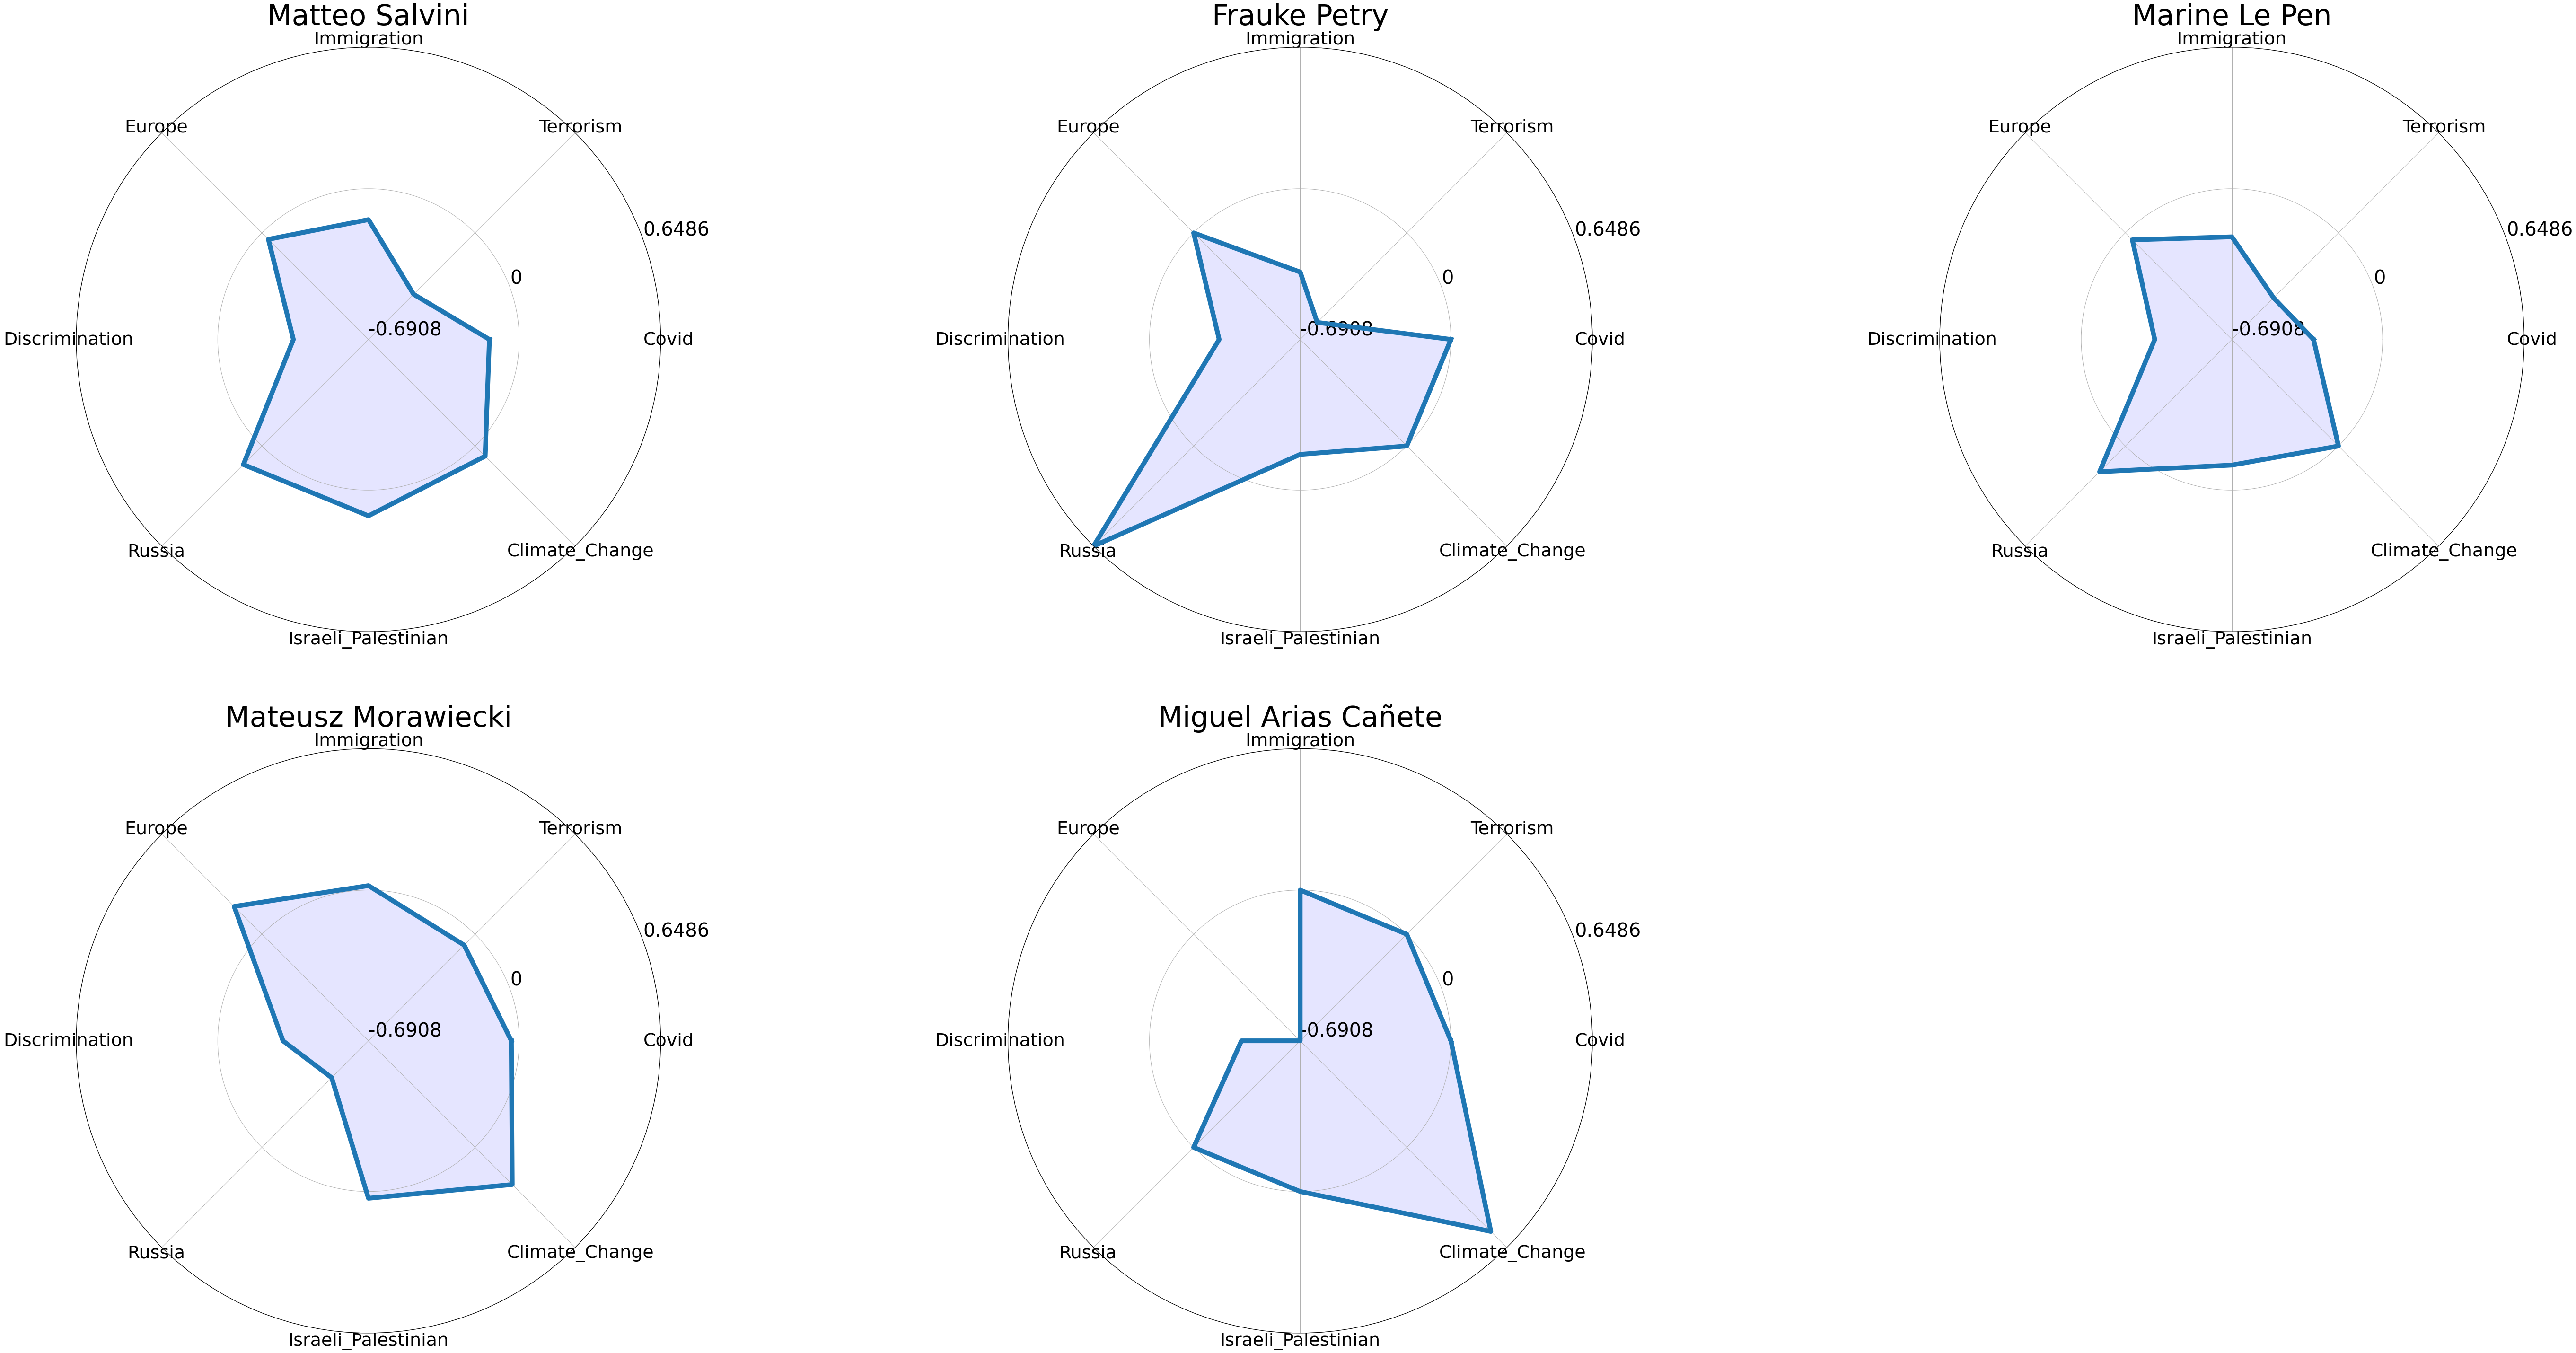

In [19]:
show_all_polarity_radar(popular_politicians, topics)

### Interpretation: Differences between right-wing politicians from different european countries

1. Miguel Arias Cañete

    - was European Commissioner for Energy and Climate Action => highly postive on climate change makes sense  
    - no quotes on most topics and one on europe and one related to discrimination (see diostributions per topics below) => doesnt tell us anything  
      => not relevant, alternative politicians: There is no right-wing party in spain, only some very small far-right partys which almost don't have any quotes at all  
    - other politicians which were quoted relativly often are prime ministers and entreprenuers who were in politics for some time in the past.  
      => spain not relevant in this analysis  

2. Frauke Petry
    - unfortunately for Frauke Petry the quotes are concentrated on the topics of immigration, terrorism and discrimination and for the other topics we have almost no quotes (see distributions below). Although this focus on the immigration topic could make sense, since during her time as the leader of her party this topic was the most important topic of her party, following the "immigration crisis" in 2015, and is the reason for the partys success in Germany.
        
2.  Difference between Mateusz Morawiecki and the other right-wing polticians: (Mateusz Morawiecki the polish prime minister and the only right-wing poltician actually leading a government in the countries we considered)

    - While the other right-wing politicians are quoted in general more positivly on Russia, Mateusz Morawiecki's quotes on russia are very negative. Poland due to its proximity to russia, its history and the events in Ukrain feels threatened. ("Once Nord Stream 2 is built, Putin can do with Ukraine whatever he wants, and then we have potentially his army on the eastern border of the EU,")

    - Mateusz Morawiecki is, according to the average polarity score, more positive on the topic EU than the other right-wings. If we look into the quotes, they are mostly Brexit related and mostly in favour of keeping Britian in the EU ("So let's make sure we hook London to the continent."). While when looking into the quotes of e.g. Matteo Salvini, we get sentences like: "The enemy is no longer the south and Rome but external enemies, in particular, the European Union and immigrants".
    
3. Matteo Salvini and Mateusz Morawiecki are postive on israeli_palestinian topic, while Marine Le Pen and Frauke Petri are negative.
    - In this case the quotes are unclear. For Marine Le Pen e.g., they are only loosly related to the topic via mentioning terms like islam, Israel or the middle east. While for Matteo Salvini e.g. the quotes are realted to the topic, but it is still difficult even as human what a positive or negative quote would be. Is a quote in favour of Israel a positive quote? So the topic is not well formulated in this case.
    
4. Terrorism is generally talked about in a more negative language (negative score). The quotes are mostly related to terror attacks and ISIS. So it does make sense that most european politian will generally talk negativly about terrorism.

5. Also immigration is a generally negativly talked about topic, as one would expect from right-wing politicians. The exception seems to be the polish prim minister Mateusz Morawiecki. But if we look at the quotes, the positive quotes are mostly talking in a positive way about polands/european immigration policy (wishes).("An ever greater number of countries is becoming convinced that the best solution is not to forcibly relocate refugees [ within the EU ] nor to impose fines on countries that refuse to accept them, but to expand our collaboration to help those countries which are the source of the refugee flows to Europe, as well as to harden the external borders of the European Union,") This also show that the avg score positivity score can also be flawed, especially if there are bnot many quotes or it can be misleading if the general language is positve, but the actual meaning is opposing a position.

6. Covid would be an interesting topic, but unfortunately, since it only appeard at the end of the examined time period, there are almost no quotes by right-wing polticians. During the beginning of Covid, the oppinion of a non-government european politician from a smaller party was probably not important enough for the "New York Times".

### Distribution of polarity scores for right-wing politicians/topics

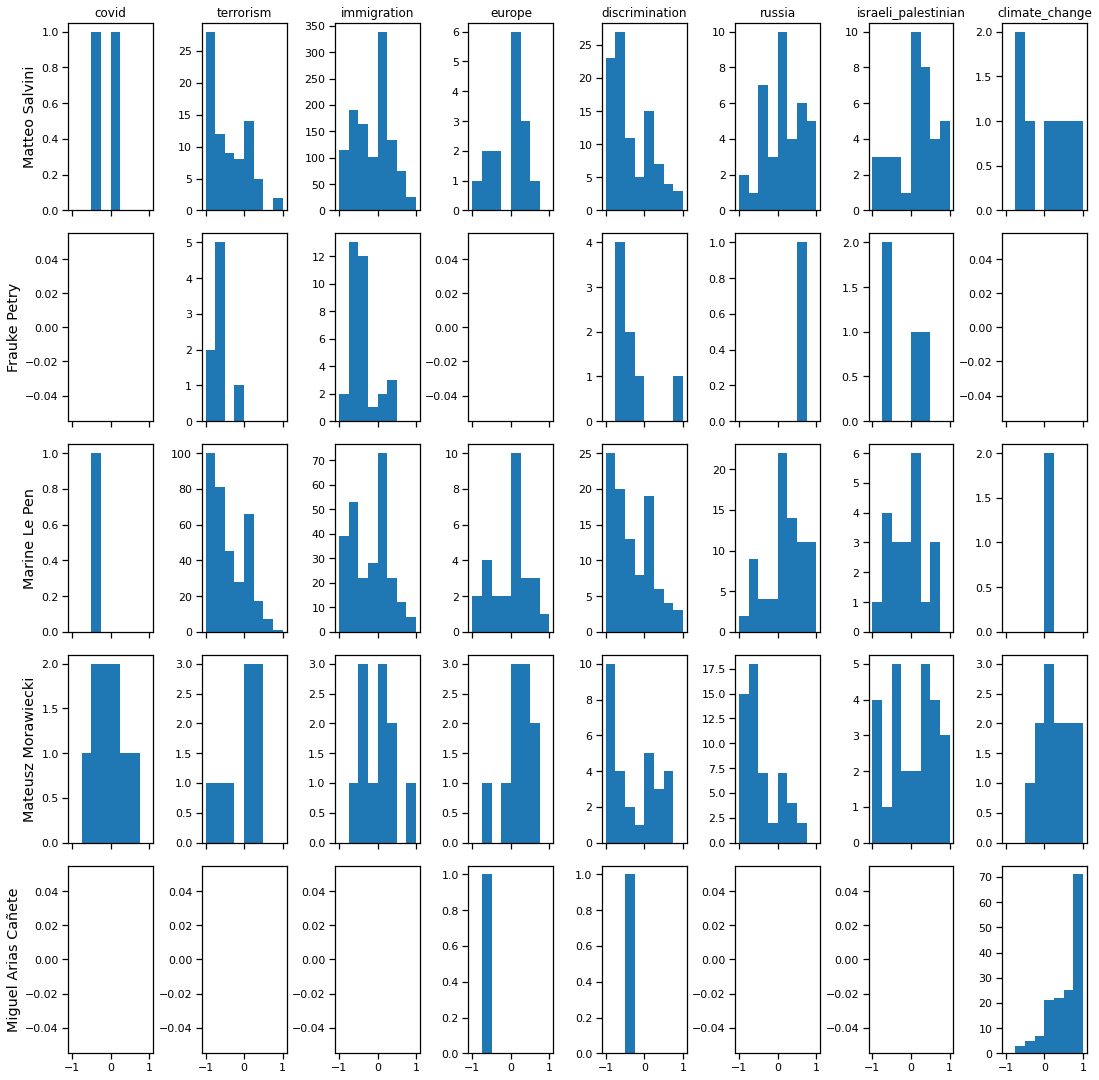

In [20]:
show_distr_speaker_topic(popular_politicians, topics, quotes_by_topic = quotes)

If we take a look at the distribution of quote and polarity and the total number of quotes, one can see that we often don't have enough quotes in a given topic for all of the considered right-wing politicians or the other way around. This is probably caused by the nature of the dataset, being from a US news paper and trying to analyse european politicians from smaller parties. But as you see below, for high-profile politicians like heads of government the situation gets better.

## Step3: (Not actually part of the research question, but still interesting) How do right-wing politicians compare to heads of government in their respective countries?

So, we look at the heads of government of each country, which were in power for a long time in the timeframe of the dataset, in order to compare them with the most quoted right wing politicians. Except for Poland and Spain, in Poland there the government is lead by the right-wing party and in Spain, as mentioned before, there is no "relevant" right-wing party.

In [21]:
heads_of_gov = {
    'speaker':['Matteo Renzi', 'Angela Merkel', 'Emmanuel Macron'],
    'political_party':['Democratic Party', 'Christian Democratic Union', 'La République En Marche']
}
heads_of_gov = pd.DataFrame(heads_of_gov)

In [22]:
heads_of_gov

,speaker,political_party
0,Matteo Renzi,Democratic Party
1,Angela Merkel,Christian Democratic Union
2,Emmanuel Macron,La République En Marche


Again, calculating the average polarity scores per politician:

In [23]:
for topic in topics:
    heads_of_gov[str(topic) + '_avg_polarity'] = heads_of_gov.apply(lambda row: calculate_avg_polarity_per_speaker(row, quotes[topic]), axis=1)

In [24]:
right_wings_and_gov = heads_of_gov.append(popular_politicians.query('speaker != "Mateusz Morawiecki"').query('speaker != "Miguel Arias Cañete"'), ignore_index=True)
right_wings_and_gov

,speaker,political_party,covid_avg_polarity,terrorism_avg_polarity,immigration_avg_polarity,europe_avg_polarity,discrimination_avg_polarity,russia_avg_polarity,israeli_palestinian_avg_polarity,climate_change_avg_polarity
0,Matteo Renzi,Democratic Party,0.381800,-0.340264,-0.185248,-0.215911,-0.525092,0.118983,0.149933,0.123475
1,Angela Merkel,Christian Democratic Union,-0.051979,-0.419350,-0.054611,0.101321,-0.222372,0.060315,0.100011,0.212548
2,Emmanuel Macron,La République En Marche,-0.058474,-0.406522,-0.092193,0.131517,-0.218754,0.104715,0.156497,0.101173
3,Matteo Salvini,Lega Nord,-0.136600,-0.398185,-0.141640,-0.041887,-0.346596,0.119963,0.117676,0.065557
4,Frauke Petry,Alternative for Germany,NaN,-0.580475,-0.381997,NaN,-0.319487,0.648600,-0.164000,NaN
5,Marine Le Pen,National Rally,-0.316700,-0.420807,-0.220537,-0.045285,-0.337203,0.166771,-0.114829,0.000000


This radar plot shows the average polarity score on each topic per politician. In the upper row are the heads of government and in the lower row there the corresponding popular right-wing politicians.

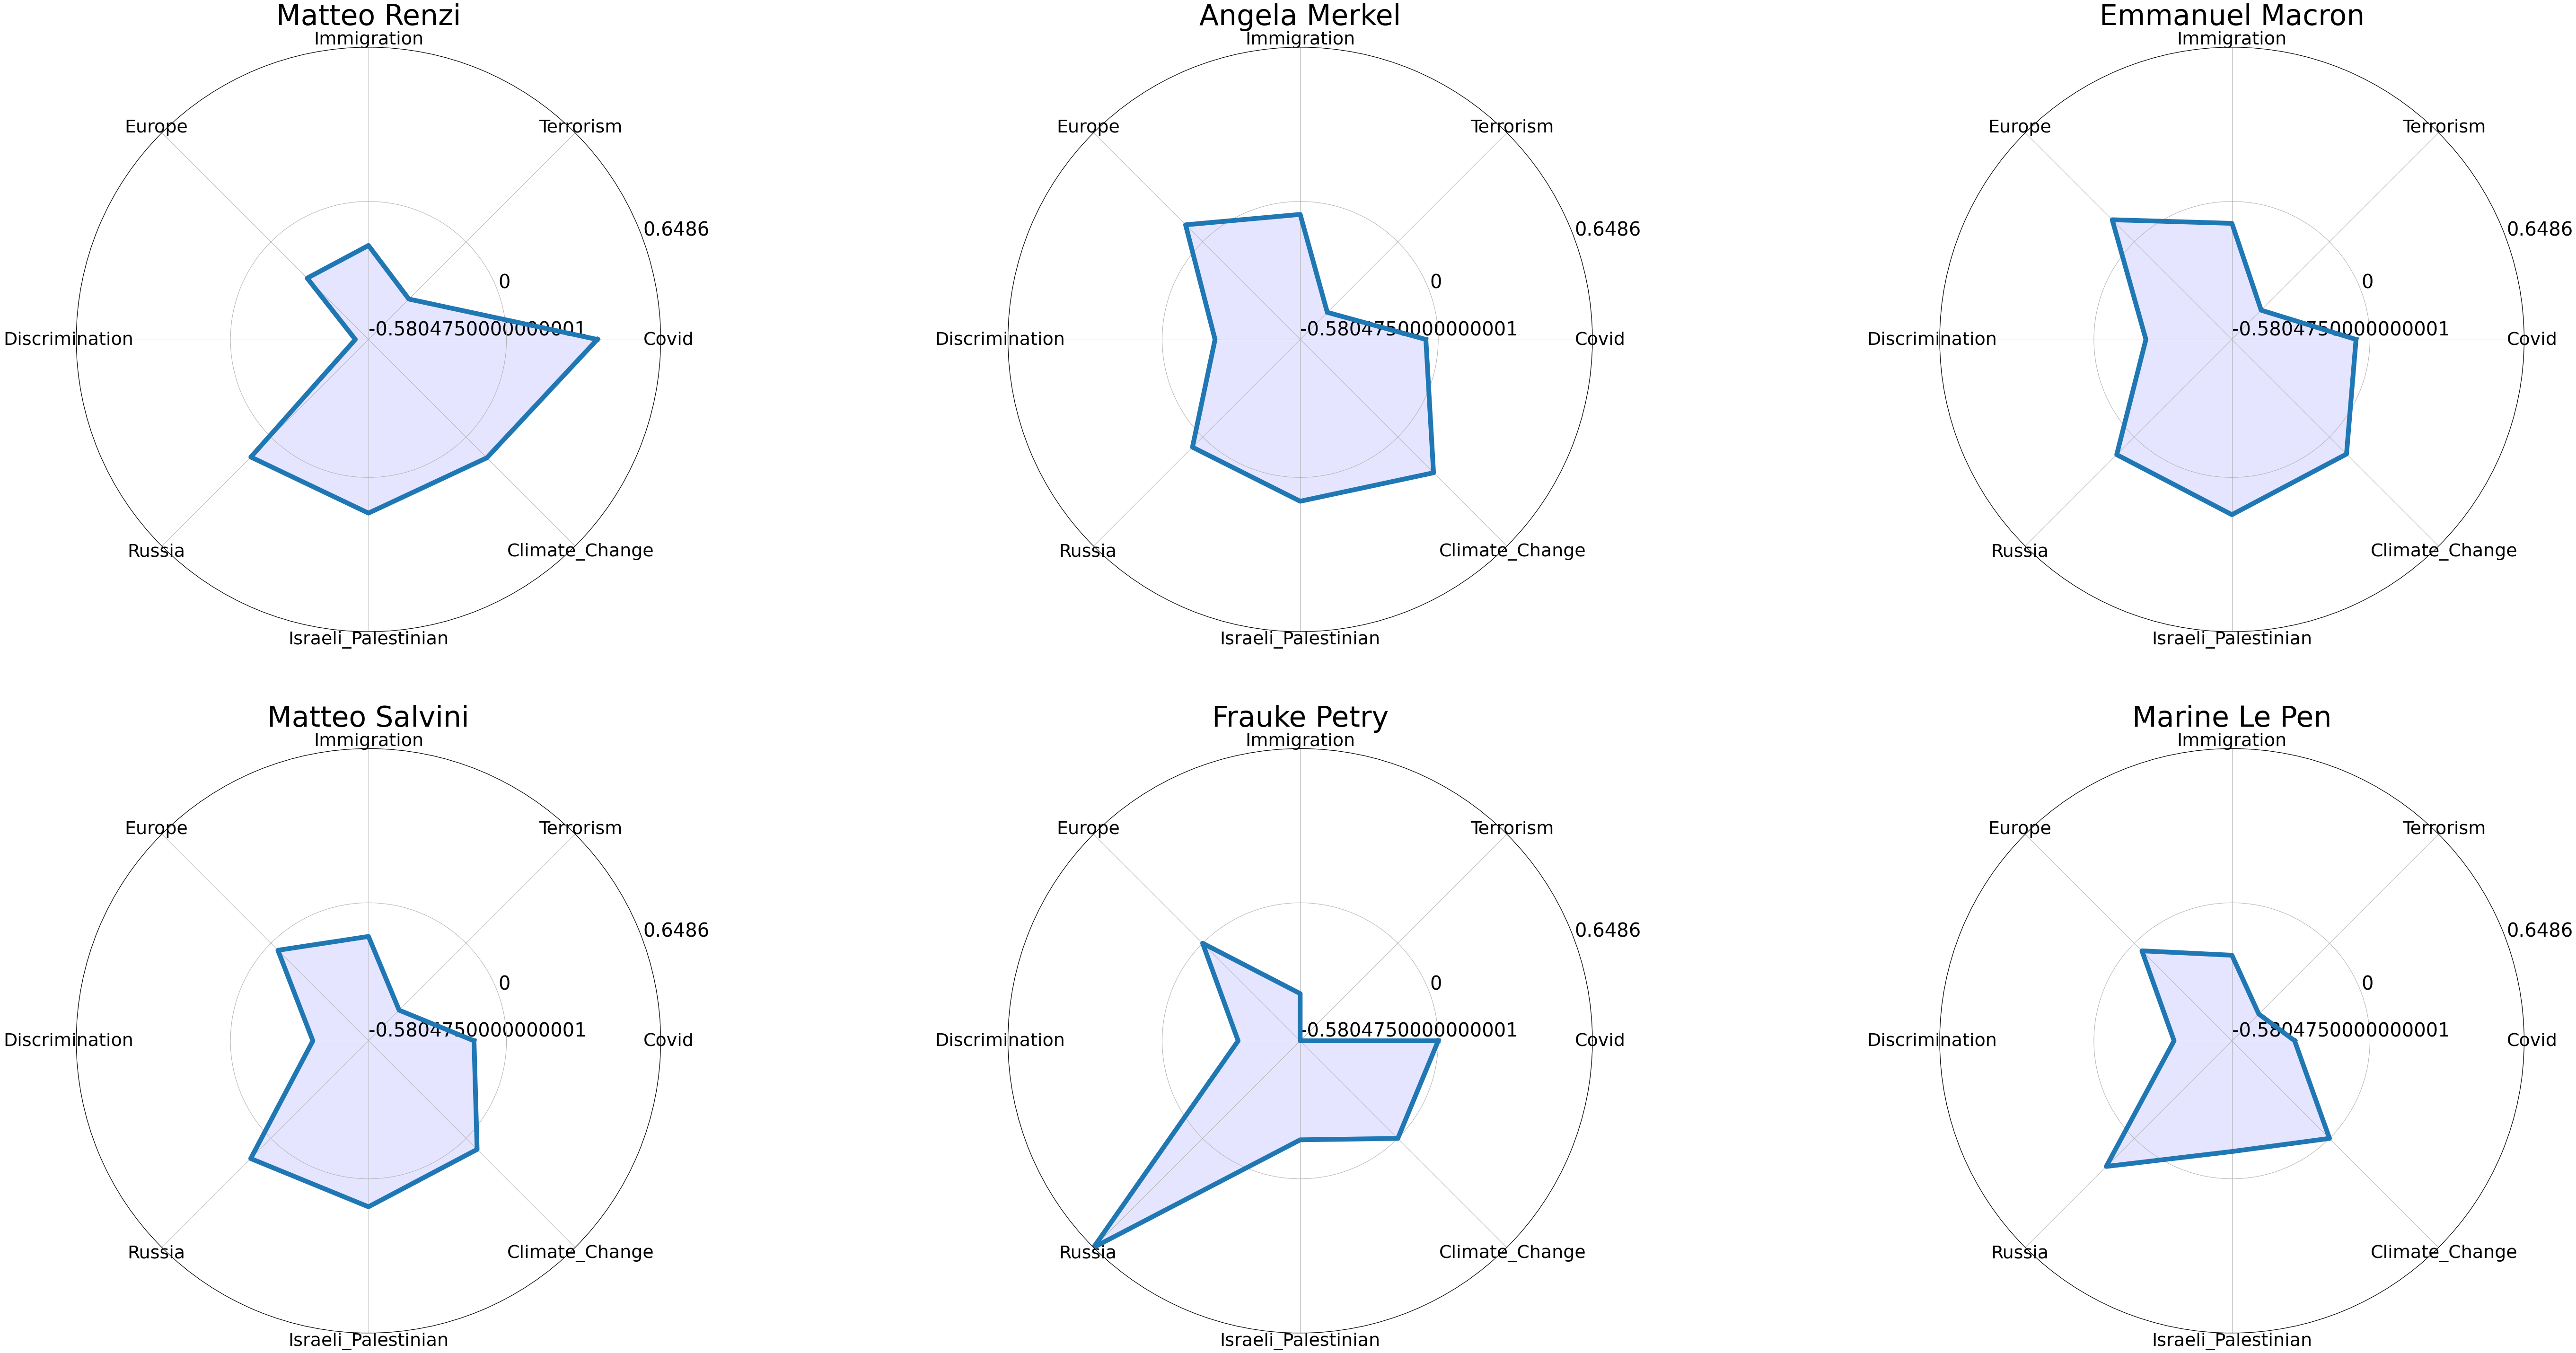

In [25]:
show_all_polarity_radar(right_wings_and_gov, topics, grid=(2,3))

------------------------------------------------------------------------------------------------------

### Interpretation: Governement vs Right-wing
In all considered countrys right-wing politicians talk more negativly about immigration than the polticians in government positions in the same country.  

Also the heads of government seem to be closer on the considered topics. This effect can also be seen in the distributions, e.g. on israeli_palestinian or terrorism. But we still would not draw any definit conclusions.


Le Pen & Petry are closer to Russia than Macron and Merkel:  
Marine Le Pen and Frauke Petry went to european right-wing meetings hosted by Russia and Le Pen even got funding for her party from a bank close to the russian governemnt.
- https://www.dw.com/en/head-of-the-afd-frauke-petry-meets-with-russian-officials-in-moscow/a-37643188
- https://www.washingtonpost.com/world/national-security/a-russian-bank-gave-marine-le-pens-party-a-loan-then-weird-things-began-happening/2018/12/27/960c7906-d320-11e8-a275-81c671a50422_story.html
For Frauke Petry there is again just one positive quote, but for Marine Le Pen the situation more clear and also supported when one would look at individual quotes.

In general, we have a far greater amount of data for globally more known politicians than the right-wing politicians. The situation would be better if we would have a similar dataset from european news papers.

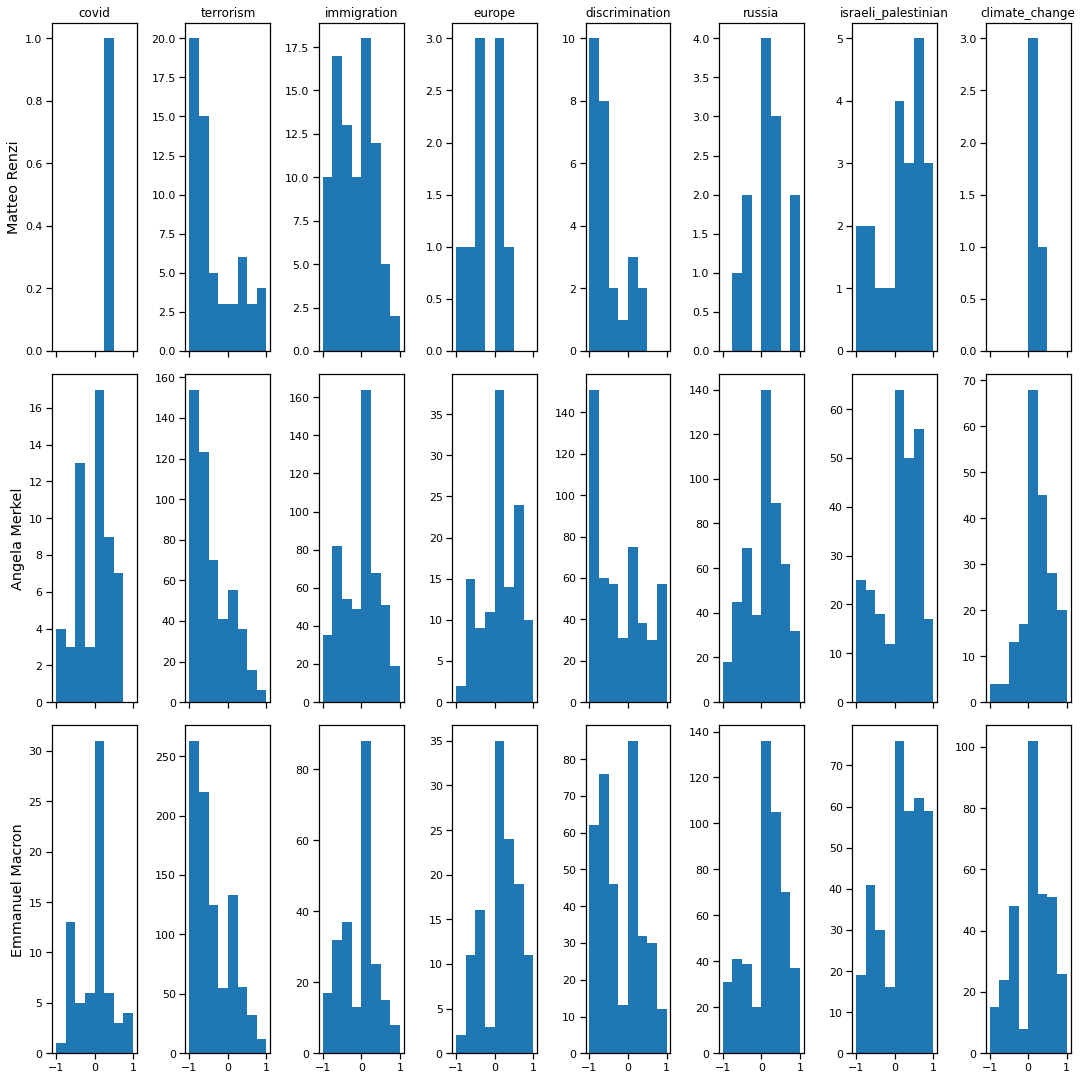

In [26]:
show_distr_speaker_topic(heads_of_gov, topics, quotes_by_topic = quotes)

----------------------------------------------------------------------